# Metadata level success analysis

In [270]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import pandas as pd

# plot style
sns.set_style('whitegrid')
sns.set_style({'font.family': 'Times New Roman'})

## Load metadata

In [271]:
metadata = pd.read_csv("metadata_merged.csv", index_col=0)

In [272]:
metadata.head()

,doi,publicationDate,publisher,subject,type,name
0,doi:10.7910/DVN/U3QJQZ,2020,harvard,Medicine; Health and Life Sciences,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
1,doi:10.7910/DVN/6KEXM7,2020,harvard,Social Sciences,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
2,doi:10.7910/DVN/EEUTHP,2019,harvard,Social Sciences,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
3,doi:10.7910/DVN/WBI9RT,2015,harvard,Social Sciences,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
4,doi:10.7910/DVN/N0PBQ9,2015,harvard,Social Sciences,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse


## Load success rate data

In [273]:
df = pd.read_csv("aggregate_results_env.csv", index_col=0)

In [274]:
len(df.doi.unique())

2085

In [275]:
df.head()

,doi,file,r32,r36,r40,result,success
0,doi:10.7910/DVN/XFQZI2,Condemnation.R,"Error in eval(expr, envir, enclos) : could not...",Error in read.dta13('Condemnation.dta') : co...,NaN,NaN,NaN
1,doi:10.7910/DVN/WGPDBS,Replication_of_Figures.R,success,success,success,success,1.0
2,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R,"Error in diag(vcovHC(DMareg, type = 'HC3')) : ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ...",0.0
3,doi:10.7910/DVN/BPON3K,fig_11_rd_placebo.R,"Error in ggsave('placebo.pdf', plot = placebo,...",success,success,success,1.0
4,doi:10.7910/DVN/BPON3K,fig_12_historical_trend.R,"Error in ggsave('historical_trend.pdf', plot =...",success,success,success,1.0


Total number of entries: 3695
Total number after bad DOIs are removed: 3695
Unique DOIs: 1447
Success: 1472 out of 3695 => 0.3983761840324763
TIL: 0 out of 3695 => 0.0
Error: 2223 out of 3695 => 0.6016238159675237


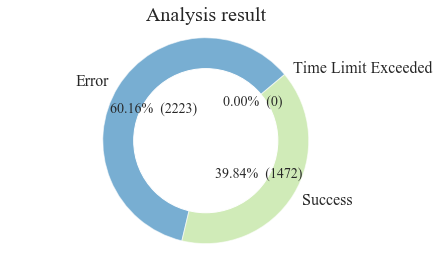

In [276]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def get_success_rates(df):
    print "Total number of entries: "+ str(len(df))
    print "Total number after bad DOIs are removed: "+ str(len(df))
    
    print "Unique DOIs: "+ str(len(df['doi'].unique()))
    
    # calculate success
    success = (df['result'] == 'success').sum()
    print "Success: " + str(success)+ " out of " + str(len(df)) +" => "+ str(success*1.0/len(df))
    
    til = (df['result'] == 'time limit exceeded').sum()
    print "TIL: " + str(til)+ " out of " + str(len(df)) +" => "+ str(til*1.0/len(df))
    
    error = len(df)-til-success
    print "Error: " + str(error)+ " out of " + str(len(df)) +" => "+ str(error*1.0/len(df))
    
    return [til, error, success]

def plot_code(df, plot_title, plot_name, aggregation=False):
    labels = ["Time Limit Exceeded",'Error', 'Success']
    if aggregation:
        sizes = get_aggregated(df)
    else:
        sizes = get_success_rates(df)
     
    fig1, ax1 = plt.subplots()
    plt.rcParams['font.size'] = 16
    ax1.pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=40,  \
            textprops={'fontsize': 14},wedgeprops={'alpha':0.6})

    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')

    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.title(plot_title, size=20)
    plt.tight_layout()

    plt.show()
    fig1.savefig("plots/{}".format(plot_name), dpi=100)
    
dfe = df[df.result.notnull()]
plot_code(dfe, "Analysis result", "fin_result2.png")

## Merge the datasets

In [286]:
total = pd.merge(df,metadata,on='doi')

In [287]:
len(total)

6832

## Merge aggrigated

In [288]:
agg = total.groupby(['doi']).success.max().reset_index()

In [289]:
agg.head()

,doi,success
0,doi:10.7910/DVN/03CDTK,NaN
1,doi:10.7910/DVN/05BSPP,0.0
2,doi:10.7910/DVN/0BFF0K,1.0
3,doi:10.7910/DVN/0BPVCH,NaN
4,doi:10.7910/DVN/0DE35E,1.0


In [290]:
len(agg)

1923

In [291]:
agg_total = pd.merge(agg, metadata, on='doi')

In [292]:
len(agg_total)

1923

## Analysis

- Drop if NaN or TLE

In [293]:
df = total
df_temp = df.drop(df[df.result.isnull() | (df['result'] == 'time limit exceeded')].index)

In [294]:
df_temp.result.isna().sum()

0

In [295]:
total = df_temp

In [296]:
def success(el):
    if pd.isna(el):
        return el
    if el == 'success':
        return 1
    if len(str(el))>1:
        return 0
    else:
        el

total['success']=total["result"].apply(success)

## Journal 

In [310]:
journals = total[total['type']=="JOURNALS"]

In [311]:
print("All journals' success rate: "+ str(journals.success.sum()*1./len(journals)))

All journals' success rate: 0.42024253731343286


In [312]:
def fix_name(el):
    return el.split('Dataverse')[0].strip()

journals.name = journals.name.apply(fix_name)

In [313]:
journals.name = journals.name.apply(
    lambda x: 'International Interactions (II)' if 'International Interactions (II)' in x else x)
journals.name = journals.name.apply(
    lambda x: 'American Journal of Political\nScience (AJPS)' if 'American Journal of Political Science (AJPS)' in x else x)
journals.name = journals.name.apply(
    lambda x: 'British Journal of\nPolitical Science' if 'British Journal of Political Science' in x else x)
journals.name = journals.name.apply(
    lambda x: 'American Political\nScience Review' if 'American Political Science Review' in x else x)
journals.name = journals.name.apply(
    lambda x: 'Review of Economics\nand Statistics' if 'Review of Economics and Statistics' in x else x)
journals.name = journals.name.apply(
    lambda x: 'Political Science Research\nand Methods (PSRM)' if 'Political Science Research and Methods (PSRM)' in x else x)

In [314]:
journals.head()

,doi,file,r32,r36,r40,result,success,publicationDate,publisher,subject,type,name
0,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R,"Error in diag(vcovHC(DMareg, type = 'HC3')) : ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ...",0,2017,ajps,Social Sciences,JOURNALS,American Journal of Political\nScience (AJPS)
1,doi:10.7910/DVN/BPON3K,fig_11_rd_placebo.R,"Error in ggsave('placebo.pdf', plot = placebo,...",success,success,success,1,2017,ajps,Social Sciences,JOURNALS,American Journal of Political\nScience (AJPS)
2,doi:10.7910/DVN/BPON3K,fig_12_historical_trend.R,"Error in ggsave('historical_trend.pdf', plot =...",success,success,success,1,2017,ajps,Social Sciences,JOURNALS,American Journal of Political\nScience (AJPS)
3,doi:10.7910/DVN/BPON3K,fig_13_plot_loyalty_df_pct.R,Error in data.table(x) : object 'x' not found,Error in data.table(x) : object 'x' not found,Error in data.table(x) : object 'x' not found,Error in data.table(x) : object 'x' not found,0,2017,ajps,Social Sciences,JOURNALS,American Journal of Political\nScience (AJPS)
4,doi:10.7910/DVN/BPON3K,fig_14_effect_on_individual_parties.R,"Error in eval(expr, envir, enclos) : could n...",success,success,success,1,2017,ajps,Social Sciences,JOURNALS,American Journal of Political\nScience (AJPS)


In [315]:
temp = journals.groupby(
    ['success', 'name']).size().reset_index().pivot(columns='success', index='name', values=0)

temp.fillna(0.0, inplace=True)
temp['total'] = [i+j for i,j in zip(temp[1],temp[0])]
#temp['total'] = [i+j for i,j in zip(temp[2],temp['total'])]

temp['s'] = [i / j * 100 for i,j in zip(temp[1], temp['total'])]
temp['f'] = [i / j * 100 for i,j in zip(temp[0], temp['total'])]
#temp['t'] = [i / j * 100 for i,j in zip(temp[2], temp['total'])]

temp = temp.sort_values(by=['total'], ascending=False).head(11)

In [316]:
temp

success,0,1,total,s,f
name,,,,,
The Journal of Politics,246.0,133.0,379.0,35.092348,64.907652
American Journal of Political\nScience (AJPS),121.0,195.0,316.0,61.708861,38.291139
British Journal of\nPolitical Science,155.0,84.0,239.0,35.146444,64.853556
Political Analysis,108.0,109.0,217.0,50.230415,49.769585
American Political\nScience Review,120.0,76.0,196.0,38.775510,61.224490
Political Science Research\nand Methods (PSRM),85.0,59.0,144.0,40.972222,59.027778
Political Behavior,70.0,73.0,143.0,51.048951,48.951049
International Studies Quarterly,65.0,40.0,105.0,38.095238,61.904762
Review of Economics\nand Statistics,40.0,32.0,72.0,44.444444,55.555556


In [317]:
names = list(temp.index)
r= range(0,len(temp['s']))

In [318]:
import seaborn as sns
sns.set_style("whitegrid")
# plot
barWidth = 0.8

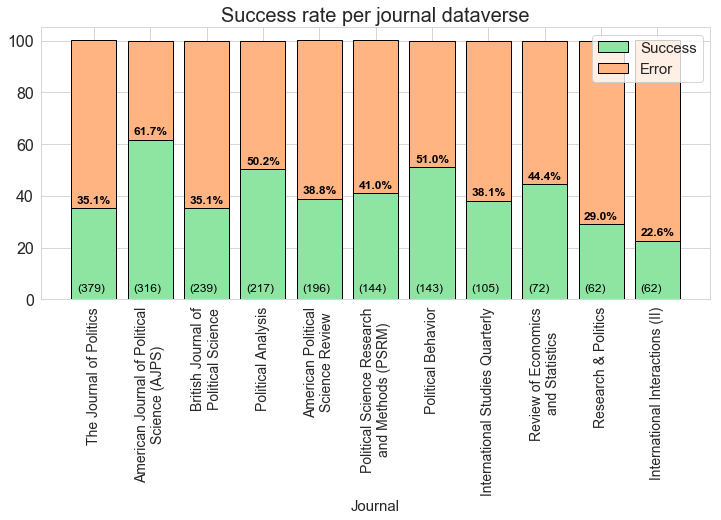

In [321]:
plt.figure(figsize=(12,5))

plt.bar(r, temp['s'], color=sns.color_palette("pastel")[2], edgecolor='black', width=barWidth, label="Success")
plt.bar(r, temp['f'], bottom=temp['s'], color=sns.color_palette("pastel")[1], edgecolor='black', width=barWidth, label="Error")

plt.xticks(r, names, rotation=90, fontsize=14)
plt.xlabel("Journal", size=15)

plt.legend(loc='best', ncol=1,prop={'size': 15})

temp['names'] = temp.index
temp = temp.reset_index(drop=True)

temp.s = temp.s.round(1)
temp.total = temp.total.astype(int)

for i, rows in temp.iterrows():
    plt.annotate(
        str(rows["s"])+"%", xy=(i-0.3, rows["s"]+2), rotation=0, color="black", size=12, weight='bold')
    plt.annotate(
        "("+str(int(rows["total"]))+")", xy=(i-0.3, 3), rotation=0, color="black", size=12)


#plt.annotate("IQSS preliminary", xy=(8, 101), color="grey", size=12)    

plt.title("Success rate per journal dataverse", size=20)

#plt.tight_layout()
#plt.savefig("publisher.png")
plt.savefig('plots/journals_rate.png', bbox_inches = "tight")
plt.show()

## Aggregated journals

In [355]:
journals = agg_total[agg_total['type']=="JOURNALS"]
journals = journals.drop(journals[journals.success.isnull()].index)

In [356]:
journals.head()

,doi,success,publicationDate,publisher,subject,type,name
2,doi:10.7910/DVN/0BFF0K,1.0,2019,BJPolS,Social Sciences,JOURNALS,British Journal of Political Science Dataverse
4,doi:10.7910/DVN/0DE35E,1.0,2018,xps,Social Sciences,JOURNALS,Journal of Experimental Political Science
5,doi:10.7910/DVN/0DLNBL,1.0,2018,jop,Social Sciences,JOURNALS,The Journal of Politics Dataverse
7,doi:10.7910/DVN/0E9KON,1.0,2016,jop,Social Sciences,JOURNALS,The Journal of Politics Dataverse
8,doi:10.7910/DVN/0EIQXL,1.0,2020,ajps,Social Sciences,JOURNALS,American Journal of Political Science (AJPS) D...


In [357]:
print("Aggregated all journals' success rate: "+ str(journals.success.sum()/len(journals)))

Aggregated all journals' success rate: 0.4729381443298969


In [358]:
def fix_name(el):
    return el.split('Dataverse')[0].strip()

journals.name = journals.name.apply(fix_name)

journals.name = journals.name.apply(
    lambda x: 'International\nInteractions (II)' if 'International Interactions (II)' in x else x)
journals.name = journals.name.apply(
    lambda x: 'American Journal of Political\nScience (AJPS)' if 'American Journal of Political Science (AJPS)' in x else x)
journals.name = journals.name.apply(
    lambda x: 'British Journal of\nPolitical Science' if 'British Journal of Political Science' in x else x)
journals.name = journals.name.apply(
    lambda x: 'American Political\nScience Review' if 'American Political Science Review' in x else x)
journals.name = journals.name.apply(
    lambda x: 'Review of Economics\nand Statistics' if 'Review of Economics and Statistics' in x else x)
journals.name = journals.name.apply(
    lambda x: 'Political Science Research\nand Methods (PSRM)' if 'Political Science Research and Methods (PSRM)' in x else x)
journals.name = journals.name.apply(
    lambda x: 'Journal of Experimental\nPolitical Science' if 'Journal of Experimental Political Science' in x else x)
journals.name = journals.name.apply(
    lambda x: 'International\nStudies Quarterly' if 'International Studies Quarterly' in x else x)


In [359]:
temp = journals.groupby(
    ['success', 'name']).size().reset_index().pivot(columns='success', index='name', values=0)

temp.fillna(0.0, inplace=True)
temp['total'] = [i+j for i,j in zip(temp[1],temp[0])]
#temp['total'] = [i+j for i,j in zip(temp[2],temp['total'])]

temp['s'] = [i / j * 100 for i,j in zip(temp[1], temp['total'])]
temp['f'] = [i / j * 100 for i,j in zip(temp[0], temp['total'])]
#temp['t'] = [i / j * 100 for i,j in zip(temp[2], temp['total'])]

temp = temp.sort_values(by=['total'], ascending=False).head(12)

In [360]:
temp

success,0.0,1.0,total,s,f
name,,,,,
The Journal of Politics,82.0,63.0,145.0,43.448276,56.551724
American Journal of Political\nScience (AJPS),40.0,61.0,101.0,60.396040,39.603960
Political Science Research\nand Methods (PSRM),28.0,38.0,66.0,57.575758,42.424242
British Journal of\nPolitical Science,37.0,27.0,64.0,42.187500,57.812500
Political Analysis,22.0,39.0,61.0,63.934426,36.065574
International\nStudies Quarterly,35.0,20.0,55.0,36.363636,63.636364
American Political\nScience Review,26.0,25.0,51.0,49.019608,50.980392
Political Behavior,18.0,21.0,39.0,53.846154,46.153846
International\nInteractions (II),28.0,8.0,36.0,22.222222,77.777778


In [361]:
names = list(temp.index)
r= range(0,len(temp['s']))

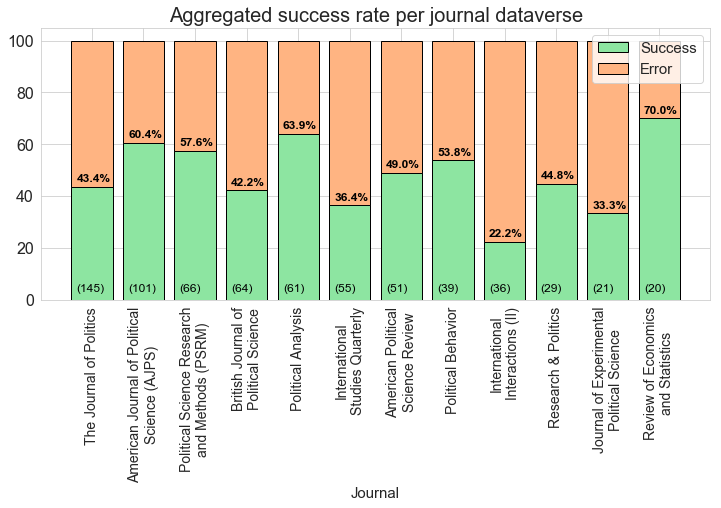

In [362]:
plt.figure(figsize=(12,5))

plt.bar(r, temp['s'], color=sns.color_palette("pastel")[2], edgecolor='black', width=barWidth, label="Success")
plt.bar(r, temp['f'], bottom=temp['s'], color=sns.color_palette("pastel")[1], edgecolor='black', width=barWidth, label="Error")

plt.xticks(r, names, rotation=90, fontsize=14)
plt.xlabel("Journal", size=15)

plt.legend(loc='best', ncol=1,prop={'size': 15})

temp['names'] = temp.index
temp = temp.reset_index(drop=True)

temp.s = temp.s.round(1)
temp.total = temp.total.astype(int)

for i, rows in temp.iterrows():
    plt.annotate(
        str(rows["s"])+"%", xy=(i-0.3, rows["s"]+2), rotation=0, color="black", size=12, weight='bold')
    plt.annotate(
        "("+str(int(rows["total"]))+")", xy=(i-0.3, 3), rotation=0, color="black", size=12)


#plt.annotate("IQSS preliminary", xy=(8, 101), color="grey", size=12)    

plt.title("Aggregated success rate per journal dataverse", size=20)

#plt.tight_layout()
#plt.savefig("publisher.png")
plt.savefig('plots/agg_journals_rate.png', bbox_inches = "tight")
plt.show()

# Journal per year

In [160]:
journals.publisher.unique()

array(['BJPolS', 'xps', 'jop', 'ajps', 'lsq', 'PSRM', 'polbehavior',
       'restat', 'JPublicPolicy', 'perspectives', 'pan', 'the_review',
       'researchandpolitics', 'isq', 'culturalanalytics',
       'internationalinteractions', 'JAERE', 'IOJ', 'economics', 'FPA',
       'isec', 'LAPS', 'world-politics', 'ipsr-risp', 'tpmnewsletter',
       'cjip', 'ps', 'jhr', 'JJPS', 'jlc', 'palcomms', 'bpsr', 'qje'],
      dtype=object)

In [161]:
top = ['jop', 'ajps', 'PSRM', 'BJPolS', 'pan', 'isq']

In [162]:
journals = journals.drop(journals[~journals.publisher.isin(top)].index)

In [163]:
journals.name.unique()

array(['British Journal of Political Science', 'The Journal of Politics',
       'American Journal of Political\nScience (AJPS)',
       'Political Science Research\nand Methods (PSRM)',
       'Political Analysis', 'International Studies Quarterly'],
      dtype=object)

In [164]:
temp = journals.groupby(
    ['success', 'name', 'publicationDate']) .size().reset_index()

In [165]:
temp = temp.pivot_table(index=['name', 'publicationDate'], columns=['success']).reset_index()

In [166]:
temp.head()

name publicationDate    0  \
success                                                                 0.0   
0        American Journal of Political\nScience (AJPS)            2015  1.0   
1        American Journal of Political\nScience (AJPS)            2016  5.0   
2        American Journal of Political\nScience (AJPS)            2017  7.0   
3        American Journal of Political\nScience (AJPS)            2018  9.0   
4        American Journal of Political\nScience (AJPS)            2019  9.0   

               
success   1.0  
0         3.0  
1         8.0  
2        12.0  
3        14.0  
4        19.0

In [167]:
temp.fillna(0.0, inplace=True)
temp['total'] = [i+j for i,j in zip(temp[0][1],temp[0][0])]

temp['s'] = [i / j * 100 for i,j in zip(temp[0][1], temp['total'])]
temp['f'] = [i / j * 100 for i,j in zip(temp[0][0], temp['total'])]

In [168]:
temp.head()

name publicationDate    0  \
success                                                                 0.0   
0        American Journal of Political\nScience (AJPS)            2015  1.0   
1        American Journal of Political\nScience (AJPS)            2016  5.0   
2        American Journal of Political\nScience (AJPS)            2017  7.0   
3        American Journal of Political\nScience (AJPS)            2018  9.0   
4        American Journal of Political\nScience (AJPS)            2019  9.0   

              total          s          f  
success   1.0                              
0         3.0   4.0  75.000000  25.000000  
1         8.0  13.0  61.538462  38.461538  
2        12.0  19.0  63.157895  36.842105  
3        14.0  23.0  60.869565  39.130435  
4        19.0  28.0  67.857143  32.142857

In [ ]:
temp.iterrows()

fig, ax = plt.subplots()
    sb.regplot(x='round', y='money', data=firm, ax=ax)
    ax2 = ax.twinx()
    sb.regplot(x='round', y='dead', data=firm, ax=ax2, color='r')

In [ ]:
def f(x,y,z, **kwargs):
    fig, ax = plt.subplots()
    ax = sns.barplot(x, y, color="#99ffcc", width=0.5)
    ax2 = ax.twinx()
    sns.barplot(x, z, ax=ax2, **kwargs)
    #for i, rows in temp.iterrows():
    #    ax.annotate("("+str(int(rows["total"]))+")", xy=(i-0.2, 3), rotation=0, color="black", size=12)

g = sns.FacetGrid(temp, col="name", col_wrap=2, height=5)
g.map(f, "publicationDate", "total", 's')

g.set_axis_labels("Year", "Success rate (%)")
#g.set(xticks=[10, 30, 50], yticks=[2, 6, 10])

In [ ]:
#for ax in g.axes.ravel():
#    for p in ax.patches:
#        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    



temp.fillna(0.0, inplace=True)
temp['total'] = [i+j for i,j in zip(temp[1],temp[0])]
#temp['total'] = [i+j for i,j in zip(temp[2],temp['total'])]

temp['s'] = [i / j * 100 for i,j in zip(temp[1], temp['total'])]
temp['f'] = [i / j * 100 for i,j in zip(temp[0], temp['total'])]
#temp['t'] = [i / j * 100 for i,j in zip(temp[2], temp['total'])]

#temp = temp.sort_values(by=['total'], ascending=False).head(12)

# Re-execution rate per publication year

In [232]:
# plot style
sns.set_style('whitegrid')
sns.set_style({'font.family': 'Times New Roman'})

def plot_func(temp, ptitle, pname):
    temp.fillna(0.0, inplace=True)
    temp['total'] = [i+j for i,j in zip(temp[1],temp[0])]

    temp['s'] = [i* 100./ j  for i,j in zip(temp[1], temp['total'])]
    temp['f'] = [i* 100./ j  for i,j in zip(temp[0], temp['total'])]
    #temp['t'] = [i / j * 100 for i,j in zip(temp[2], temp['total'])]

    names = list(temp.index)
    r= range(0,len(temp['s']))

    plt.figure(figsize=(6,5))

    barWidth = 0.8
    
    sns.barplot(x=r, y="s", data=temp,  color=sns.color_palette("Set2")[0], label="Success")
    sns.barplot(x=r, y="f", data=temp, bottom=temp['s'], color=sns.color_palette("Set2")[1], label="Error")
    
    #plt.bar(r, temp['s'], color='#b5ffb9', edgecolor='black', width=barWidth, label="Success")
    #plt.bar(r, temp['f'], color='#cce6ff', bottom=temp['s'], edgecolor='black', width=barWidth, label="Error")

    plt.xticks(r, names, rotation=90, fontsize=15)
    plt.xlabel("Year", size=15)
    plt.ylabel("Success rate (%)", size=15)

    plt.legend(loc='best', ncol=1,prop={'size': 12})

    temp['year'] = temp.index
    #temp['names'] =temp['names'].apply(fix_name)
    temp = temp.reset_index(drop=True)

    #temp.s = temp.s+temp.t
    temp.s = temp.s.round(1)
    temp.total = temp.total.astype(int)

    for i, rows in temp.iterrows():
        if rows["s"]<=0:
            plt.annotate(
                str(rows["s"])+"%", xy=(i-0.3, rows["s"]+10), rotation=0, color="black", size=12, weight='bold')
            plt.annotate(
                "("+str(int(rows["total"]))+")", xy=(i-0.3, 3), rotation=0, color="black", size=12)
        elif rows["s"]>95:
            plt.annotate(
                str(rows["s"])+"%", xy=(i-0.3, rows["s"]-5), rotation=0, color="black", size=12, weight='bold')
            plt.annotate(
                "("+str(int(rows["total"]))+")", xy=(i-0.3, 3), rotation=0, color="black", size=12)
        else:
            plt.annotate(
                str(rows["s"])+"%", xy=(i-0.3, rows["s"]+2), rotation=0, color="black", size=12, weight='bold')
            plt.annotate(
                "("+str(int(rows["total"]))+")", xy=(i-0.3, 3), rotation=0, color="black", size=12)


    plt.title(ptitle, size=20)

    plt.savefig("plots/{}.png".format(pname), bbox_inches = "tight")
    plt.show()

In [233]:
total = total[total['publicationDate'] > 2014]

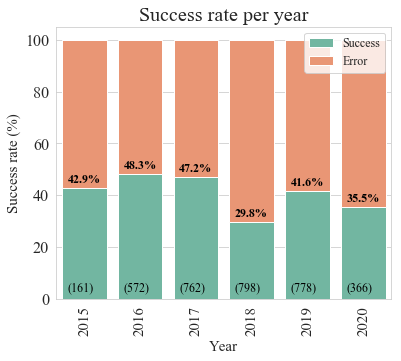

In [234]:
temp = total.groupby(
    ['success', 'publicationDate']).size().reset_index().pivot(
    columns='success', index='publicationDate', values=0)
plot_func(temp, ptitle="Success rate per year", pname="per_year")

In [235]:
total['r32_success']=total["r32"].apply(success)
total['r36_success']=total["r36"].apply(success)
total['r40_success']=total["r40"].apply(success)

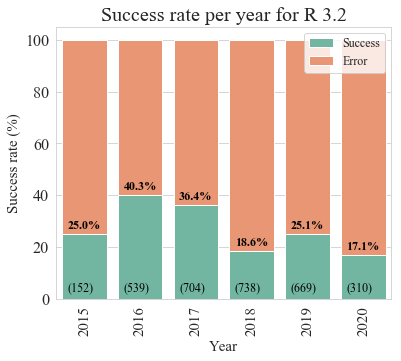

In [236]:
temp = total.groupby(
    ['r32_success', 'publicationDate']).size().reset_index().pivot(
    columns='r32_success', index='publicationDate', values=0)
plot_func(temp, ptitle="Success rate per year for R 3.2", pname="per_year_r32")

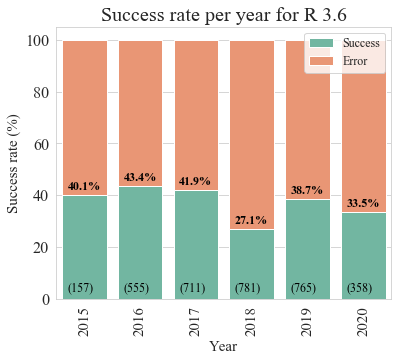

In [237]:
temp = total.groupby(
    ['r36_success', 'publicationDate']).size().reset_index().pivot(
    columns='r36_success', index='publicationDate', values=0)
plot_func(temp, ptitle="Success rate per year for R 3.6", pname="per_year_r36")

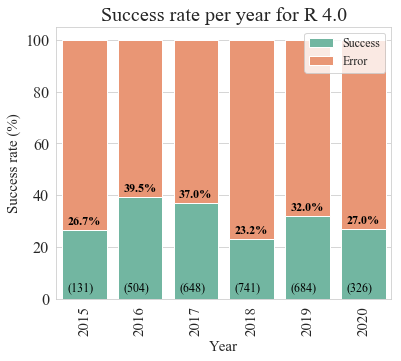

In [238]:
temp = total.groupby(
    ['r40_success', 'publicationDate']).size().reset_index().pivot(
    columns='r40_success', index='publicationDate', values=0)
plot_func(temp, ptitle="Success rate per year for R 4.0", pname="per_year_r40")

In [239]:
temp

r40_success,0.0,1.0,total,s,f,year
publicationDate,,,,,,
2015,96,35,131,26.717557,73.282443,2015
2016,305,199,504,39.484127,60.515873,2016
2017,408,240,648,37.037037,62.962963,2017
2018,569,172,741,23.211876,76.788124,2018
2019,465,219,684,32.017544,67.982456,2019
2020,238,88,326,26.993865,73.006135,2020


# Re-execution rate per subject

In [279]:
total['subject'] = total.subject.str.replace(';Social Sciences', '')
total.groupby(['subject']).size().nlargest(10)

subject
Social Sciences                                                                              6079
Earth and Environmental Sciences                                                              102
Medicine; Health and Life Sciences                                                             95
Law                                                                                            84
Business and Management                                                                        73
Computer and Information Science                                                               62
Arts and Humanities                                                                            55
Earth and Environmental Sciences;Mathematical Sciences;Medicine; Health and Life Sciences      47
Other                                                                                          39
Mathematical Sciences                                                                          25
dtype: int64

In [280]:
total.subject = total.subject.apply(lambda x: 'Physics' if 'Physics' in x else x)
total.subject = total.subject.apply(lambda x: 'Health and\nLife Sciences' if 'Health and Life Sciences' in x else x)
total.subject = total.subject.apply(lambda x: 'Earth and\nEnvironmental Sciences' if 'Earth and Environmental Sciences' in x else x)
total.subject = total.subject.apply(lambda x: 'Law' if 'Law' in x else x)
total.subject = total.subject.apply(lambda x: 'Computer and\nInformation Science' if 'Computer and Information Science' in x else x)
total.subject = total.subject.apply(lambda x: 'Agricultural Sciences' if 'Agricultural Sciences' in x else x)
total.subject = total.subject.apply(lambda x: 'Business and\nManagement' if 'Business and Management' in x else x)

In [281]:
total.groupby(['subject']).size()

subject
Agricultural Sciences                  22
Arts and Humanities                    55
Business and\nManagement               74
Computer and\nInformation Science     100
Earth and\nEnvironmental Sciences     130
Health and\nLife Sciences             176
Law                                   109
Mathematical Sciences                  25
Other                                  39
Physics                                23
Social Sciences                      6079
dtype: int64

In [282]:
temp = total.groupby(
    ['success', 'subject']).size().reset_index().pivot(columns='success', index='subject', values=0)
temp

success,0.0,1.0
subject,,
Agricultural Sciences,18,3
Arts and Humanities,31,5
Business and\nManagement,35,25
Computer and\nInformation Science,25,20
Earth and\nEnvironmental Sciences,48,29
Health and\nLife Sciences,54,79
Law,31,34
Mathematical Sciences,10,4
Other,13,15


In [283]:
#temp.fillna(0.0, inplace=True)
temp['total'] = [i+j for i,j in zip(temp[1],temp[0])]
#temp['total'] = [i+j for i,j in zip(temp[2],temp['total'])]

temp['s'] = [(i*1./j) * 100 for i,j in zip(temp[1], temp['total'])]
temp['f'] = [(i*1./j) * 100 for i,j in zip(temp[0], temp['total'])]

#temp['sortby'] = [i+j for i,j in zip(temp['s'], temp['t'])]

temp = temp.sort_values(by=['s'], ascending=False).head(11)
temp

success,0.0,1.0,total,s,f
subject,,,,,
Health and\nLife Sciences,54,79,133,59.398496,40.601504
Other,13,15,28,53.571429,46.428571
Law,31,34,65,52.307692,47.692308
Computer and\nInformation Science,25,20,45,44.444444,55.555556
Business and\nManagement,35,25,60,41.666667,58.333333
Social Sciences,1759,1184,2943,40.231057,59.768943
Earth and\nEnvironmental Sciences,48,29,77,37.662338,62.337662
Mathematical Sciences,10,4,14,28.571429,71.428571
Agricultural Sciences,18,3,21,14.285714,85.714286


In [284]:
names = list(temp.index)
r= range(0,len(temp['s']))

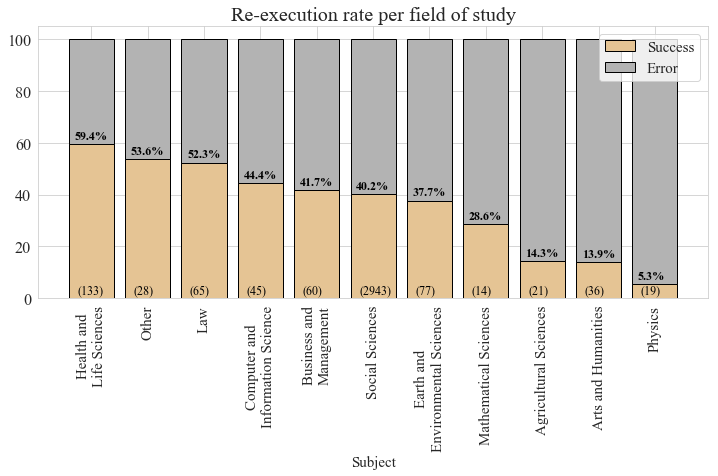

In [285]:
plt.figure(figsize=(12,5))

plt.bar(r, temp['s'], color=sns.color_palette("Set2")[6], edgecolor='black', width=barWidth, label="Success")
#plt.bar(r, temp['t'], bottom=temp['s'], color='#fFF842', edgecolor='black', width=barWidth, label="TLE")
plt.bar(r, temp['f'], bottom=temp['s'], color=sns.color_palette("Set2")[7], edgecolor='black', width=barWidth, label="Error")

plt.xticks(r, names, rotation=90, fontsize=15)
plt.xlabel("Subject", size=15)

plt.legend(loc='best', ncol=1,prop={'size': 15})

temp['year'] = temp.index
temp = temp.reset_index(drop=True)

#temp.s = temp.s+temp.t
temp.s = temp.s.round(1)
temp.total = temp.total.astype(int)

for i, rows in temp.iterrows():
    if rows["s"]<=0:
        plt.annotate(
            str(rows["s"])+"%", xy=(i-0.3, rows["s"]+10), rotation=0, color="black", size=12, weight='bold')
        plt.annotate(
            "("+str(int(rows["total"]))+")", xy=(i-0.25, 2), rotation=0, color="black", size=12)
    else:
        plt.annotate(
            str(rows["s"])+"%", xy=(i-0.3, rows["s"]+2), rotation=0, color="black", size=12, weight='bold')
        plt.annotate(
            "("+str(int(rows["total"]))+")", xy=(i-0.25, 2), rotation=0, color="black", size=12)


plt.title("Re-execution rate per field of study", size=20)

plt.savefig("plots/subject_new2.png", bbox_inches = "tight")
plt.show()